# Titanic Survival

This Titanic dataset contains information about the passengers that can be used to predict their survival rate. Exploratory data analysis, feature engineering, and hyperparameter tuning will be discussed.

The dataset has the following columns:
- PassengerID: index
- Survived: whether the passenger survived
- Pclass: ticket class
- Name: name of the passerger, title
- Sex: male or female
- Age: age in years
- Sibsp: number of siblings/ spouses aboard the Titanic
- Parch: number of parents/ children aboard the Titanic
- Ticket: ticket number
- Fare: fare for ticket
- Cabin: cabin number
- Embarked: port of embarkation

In [1]:
import opendatasets as od
import zipfile
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV



## Getting Data

In [2]:
# od.download("https://www.kaggle.com/c/titanic/data")
# with zipfile.ZipFile(os.path.join(os.curdir, "titanic/titanic.zip"), "r") as zip:
#     zip.extractall(os.curdir)
# os.remove(os.path.join(os.curdir, "titanic/titanic.zip"))
# os.removedirs(os.path.join(os.curdir, "titanic"))
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## General information about the dataset

In [3]:
train.info()
print('\n')
print(train.isnull().sum())
print('\n')
print(test.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64



As we can see, there are five categorical features ("Name", "Sex", "Ticket", "Cabin", "Embarked"), six numerical features ("PassengerID", "Pclass", "Age", "SibSp", "Parch", "Fare"), and a binary target ("Survived"). "PassengerID" is just an index column that carries no information about survival rate, so we can safely remove it from the dataset. "Age", "Cabin", and "Fare" all have missing values, so we have to try filling these missing values during data cleaning.

## Exploratory data analysis & Feature engineering

Since the goal is to create a model that uses the given features to predict the survival rate ("Survived"), we need to investigate the correlation between these features and "Survived". In addition, we need to investigave the distributions of "Age", "Fare", and "Cabin" to fill the missing values.


### Missing values - Age

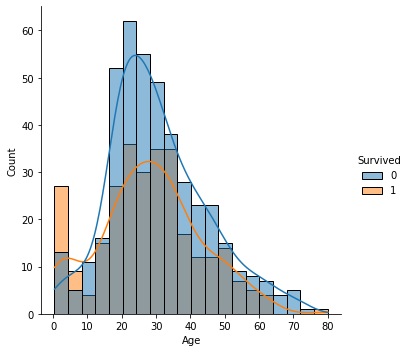

In [4]:
# Age
sns.displot(x='Age',data=train,kde=True, hue='Survived')

In terms of age distribution, there is a clear difference between survived group and non-survived group. In other words, "Age" carries important information about the survival rate. Let's see how to impute missing values in "Age". Technically, we could investigate how "Age" depends on the other features and predict missing values with a regression model. However, not all features are relevant. We can choose a few important features.

In [5]:
train.drop(columns='PassengerId').corr()['Age'].abs().sort_values(ascending=False)

Age         1.000000
Pclass      0.369226
SibSp       0.308247
Parch       0.189119
Fare        0.096067
Survived    0.077221
Name: Age, dtype: float64

<AxesSubplot:xlabel='Sex', ylabel='Age'>

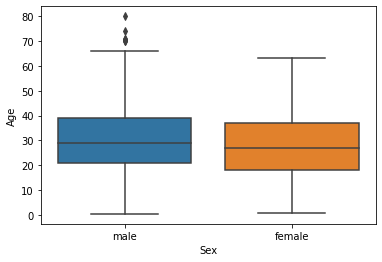

In [6]:
sns.boxplot(x='Sex',y='Age',data=train)


There seems to be a high correlation between "age" and "Pclass", "SibSp" and "Parch". There is also a difference in "age" between the male and female groups. Therefore a regression model is built based on those four features.

In [7]:
# Encoding Sex
train.Sex = train.Sex.str.get_dummies()['female']
test.Sex = test.Sex.str.get_dummies()['female']

x_age_train = train[train['Age'].notnull()][['Pclass','Sex','SibSp','Parch']]
y_age_train = train[train['Age'].notnull()]['Age']

rtr = RandomForestRegressor(n_estimators=100)
rtr.fit(x_age_train,y_age_train)

# Imputing Age
def age_impute(row, model):
    if np.isnan(row['Age']):
        row['Age'] = int(model.predict([[row['Pclass'],row['Sex'],row['SibSp'],row['Parch']]]))
        return row
    else:
        return row
        
for i in range(len(train)):
    train.iloc[i] = age_impute(train.iloc[i],rtr)

for i in range(len(test)):
    test.iloc[i] = age_impute(test.iloc[i],rtr)

### Missing values - Cabin

Almost 80% of the "Cabin" information is missing. There won't be a reliable way of imputing those values. The first letter of the Cabin values are the decks in which the cabins are located. Let's see if there is any pattern to the "Cabin" based survival rate.


Text(0.5, 1.0, "'Cabin' Distribution")

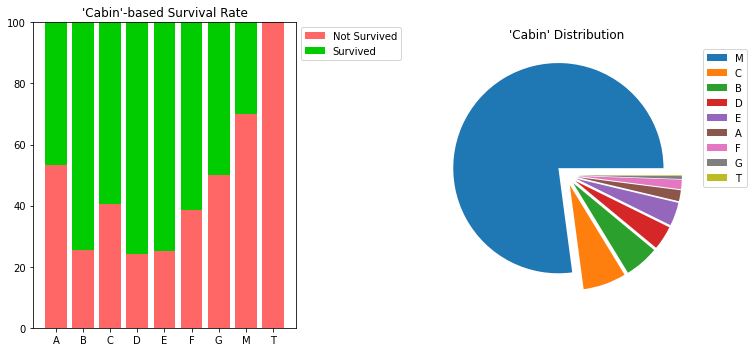

In [8]:
train.Cabin = train.Cabin.apply(lambda x: x[0] if pd.notna(x) else 'M')

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(10,5)
# Survival rate based on Cabin
percent = train[train.Survived == 0].Cabin.value_counts()/train.Cabin.value_counts()*100
ax1.bar(x=percent.index, height=percent, color='#FF6666')
ax1.bar(x=percent.index, height=100-percent, bottom=percent, color='#00CC00')
ax1.legend(["Not Survived", "Survived"], bbox_to_anchor=(1, 1))
ax1.set_title("'Cabin'-based Survival Rate")
fig.tight_layout()

# Cabin Distribution
_ = ax2.pie(x=train.Cabin.value_counts(),explode=(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1))
ax2.legend(train.Cabin.value_counts().index, bbox_to_anchor=(1, 1))
ax2.set_title("'Cabin' Distribution")


Now we could simply encode all the different "Cabin" groups, but that would produce too many features. A better approah is to group centain "Cabin" together based on survival rate. Here we group the "Cabin" into three categories: M (missing), BCDEF (survival rate > 50%), and AGT (survival rate <50%).

In [9]:
train.Cabin = train.Cabin.replace(['A','G','T'], 'AGT')
train.Cabin = train.Cabin.replace(['B','C','D','E','F'], 'BCDEF')

# Transforming test set
test.Cabin = test.Cabin.apply(lambda x: x[0] if pd.notna(x) else 'M')
test.Cabin = test.Cabin.replace(['A','G','T'], 'AGT')
test.Cabin = test.Cabin.replace(['B','C','D','E','F'], 'BCDEF')



### Missing values - Embarked

There are only two missing values. References say those two passengers embarked from S (Southampton).

In [10]:
train.Embarked = train.Embarked.fillna('S')

### Missing values - Fare

Only one missing values in the test set. This value can be imputed from the samples, who travel alone with a 3rd class ticket.


In [11]:
imputed_fare = test.groupby(['Pclass','Parch','SibSp']).Fare.median()[3][0][0]
test.Fare = test.Fare.fillna(imputed_fare)


Now let's check if we have filled all the missing values.

In [12]:
print('\n')
print(train.isnull().sum())
print('\n')
print(test.isnull().sum())



PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


### Pclass

Let's look at the survival rate based on "Pclass".

<AxesSubplot:xlabel='Pclass', ylabel='count'>

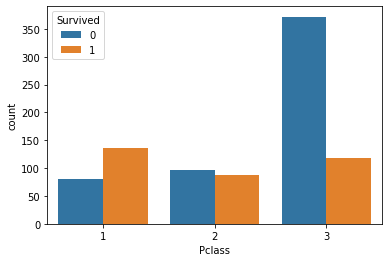

In [13]:
sns.countplot(x=train.Pclass, hue=train.Survived)

As expected, 1st class has the highest survival rate, and 3rd class has the lowest survival rate.

### Embarked

Does the port of embarkation correlates to survival rate?

<AxesSubplot:xlabel='Embarked', ylabel='count'>

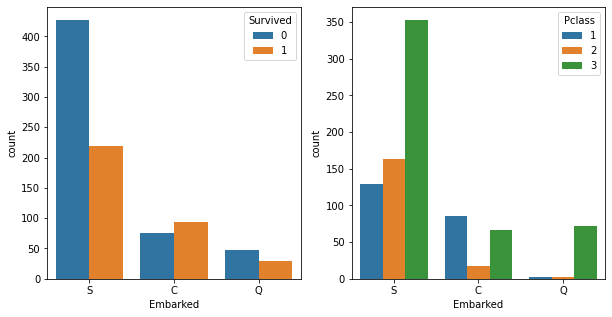

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(10,5)

sns.countplot(ax=ax1, x=train.Embarked, hue=train.Survived)
sns.countplot(ax=ax2, x=train.Embarked, hue=train.Pclass)

The trend observed in "Embarked" is mostly due to diffences in "Place". As we can see, for port C, 1st & 2nd class passengers are more than 3rd class passengers, thus it has the highest survial rate.

### Parch

<AxesSubplot:xlabel='Parch', ylabel='count'>

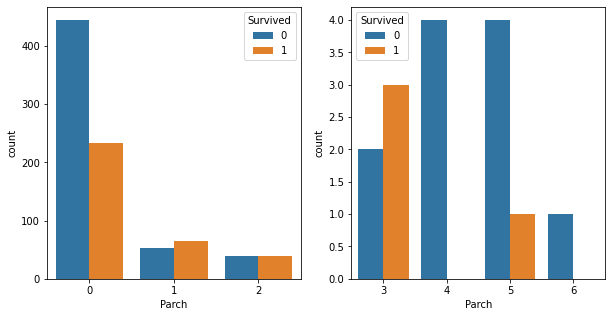

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(10,5)

sns.countplot(ax=ax1,x=train[train.Parch <=2].Parch, hue=train.Survived)
sns.countplot(ax=ax2,x=train[train.Parch >2].Parch, hue=train.Survived)

It appears that most of the passengers have 0 "Parch", and about 1/3 of them survived. For passengers with 1~3 "Parch", they have a higher survival rate. When "Parch" is greater than 3, the survial rate is significantly lower.

### SibSp

<AxesSubplot:xlabel='SibSp', ylabel='count'>

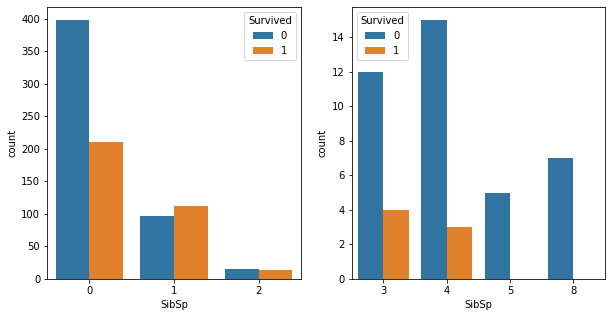

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(10,5)

sns.countplot(ax=ax1,x=train[train.SibSp <=2].SibSp, hue=train.Survived)
sns.countplot(ax=ax2,x=train[train.SibSp >2].SibSp, hue=train.Survived)

Instead of using "Parch" and "SibSp" as numerical features, we could creat subgroups based on the family size, but that would lead to more features during encoding. For "Name", we could extract a bit more information from the prefix or titles. To avoid overfitting, we will just use the features we currently have.



## Encoding

In [17]:
encoder = OneHotEncoder(drop='first')
encoded_train = encoder.fit_transform(train[['Cabin','Embarked']])
encoded_train = pd.DataFrame(encoded_train.toarray(),index=train.index,columns=['Cabin_BCDEF','Cabin_AGT','Port_C','Port_Q'])
train = pd.concat([train, encoded_train], axis=1)

encoded_test = encoder.transform(test[['Cabin','Embarked']])
encoded_test = pd.DataFrame(encoded_test.toarray(),index=test.index,columns=['Cabin_BCDEF','Cabin_AGT','Port_C','Port_Q'])
test = pd.concat([test, encoded_test], axis=1)

X_train = train.drop(columns=['PassengerId','Name','Embarked','Ticket','Cabin','Survived'])
y_train = train['Survived']

X_test = test.drop(columns=['PassengerId','Name','Embarked','Ticket','Cabin'])
y_test = pd.read_csv('gender_submission.csv', sep=',')['Survived']


<AxesSubplot:>

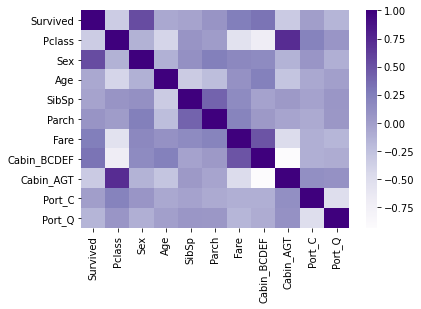

In [18]:
# Final look on correlation
sns.heatmap(train.drop(columns='PassengerId').corr(),cmap='Purples')

## Building Model

In [19]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train, y_train)
print(classification_report(y_test, rfc.predict(X_test)))


              precision    recall  f1-score   support

           0       0.85      0.83      0.84       266
           1       0.72      0.74      0.73       152

    accuracy                           0.80       418
   macro avg       0.78      0.79      0.78       418
weighted avg       0.80      0.80      0.80       418



Text(33.0, 0.5, 'Actual')

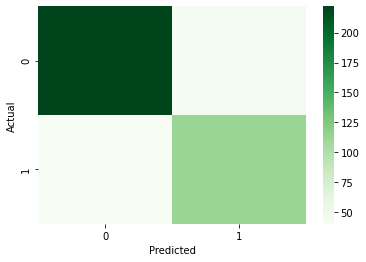

In [20]:
sns.heatmap(confusion_matrix(y_test, rfc.predict(X_test)), cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Hyperparameter tuning

In [21]:
random_grid = {
    'n_estimators': [128, 256, 512], 
    'criterion':['gini','entropy'],
    'max_depth':[20,40,60,80,100,120,None],
    'min_samples_split':[2,4,6,8,10],
    'min_samples_leaf':[1,2,4],
    'max_features':['auto','log2', None],
    'bootstrap':[True, False]
}
rfc = RandomForestClassifier()
rfc_random_search = RandomizedSearchCV(estimator=rfc, param_distributions=random_grid, n_iter=100,random_state=42,n_jobs=-1)
rfc_random_search.fit(X_train, y_train)
print(classification_report(y_test, rfc_random_search.predict(X_test)))


              precision    recall  f1-score   support

           0       0.88      0.89      0.88       266
           1       0.81      0.78      0.79       152

    accuracy                           0.85       418
   macro avg       0.84      0.84      0.84       418
weighted avg       0.85      0.85      0.85       418



Text(33.0, 0.5, 'Actual')

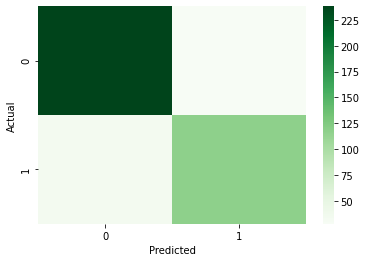

In [22]:
sns.heatmap(confusion_matrix(y_test, rfc_random_search.predict(X_test)), cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')

After random search, the model finds a better set of hyperparameters and the classification performance increased by about 5%.